# Training and inference



## Model overview

### Prithvi-WxC

The Prithvi-WxC model is a transformer-based model. It operates on a regular latitude-longitude grid, which is split up into tiles. The original model was trained using tiles of size ``(30, 32)`` pixels. The tiles are embedded into tokens of size ``(2, 2)`` yielding an internal tile size of ``(15, 16)`` tokens. Both encoder and decoder consist of alternating local and global transformer blocks. The local blocks transform each tile independently meaning interactions are limited to tokens within the same tile. The global blocks transform the corresponding pixels in each tile allowing information to be exchanged across all tiles.

![The original Prithvi-WxC architecture](./prithvi_architecture.png)

### Prithvi-WxC Regional

To adapt the Prithvi-WxC model for regional prediction, the decoder is modified slightly. Instead of decoding all tiles to product a prediction, the decoder is applied to decode only a single local tile and the global transformer blocks are modified to perform cross attention against the encoded input data instead of self attention. This ensures that the decoder produces a regional forecast but can leverage information from the global encoded state.

The model used here also reduces the tile size to ``20 x 20`` pixels, which significantly reduces the memory and compute requirements.


![The architecture of the adapted Prithvi-WxC Regional model](./prithvi_regional_architecture.png)

### Implementation

The original implementation of the Prithvi-WxC model is available though the [Prithvi-WxC package](https://github.com/NASA-IMPACT/Prithvi-WxC). The regional version (PrithviWxCRegional) is implemented in the ``pytorch_retrieve`` [package](https://github.com/simonpf/pytorch_retrieve/blob/c271ef7d78f25bc4fe20090593157b87b8f663dd/pytorch_retrieve/models/prithvi_wxc.py#L2082).

## Running the training

### Using ``pytorch_retrieve``

A simple training recipe for the Prithvi-WxC using the ``pytorch_retrieve`` package is provided in the ``model_small`` directory. The directory contains three files ``model.toml``, ``training.toml``, and ``compute.toml``, which describe the model configuration, training schedule, and compute configuration, respectively. The training can be run by executing the ``pytroch_retrieve train`` command in the ``model_small`` directory.

````
cd model_small
pytorch_retrieve train
````

The training will produce logging data monitoring the training progress. The logs can be inspected using tensorboard (``tensorboard --logdir logs``). Model checkpoints from the end of each epoch are stored in the ``checkpoints`` directory. The trained model will be stored in a file ``prithvi_regional_small.pt``.

### Manual training

For more fine-grained control over training, the ``PrithviWxCRegional`` model can be instantiated directly yielding a PyTorch module that can be trained using typical PyTorch or lightning workflows.

> **Note**: The parameters below were chosen should be chosen to match the configuration of the pre-trained Prithvi-WxC models. If they deviate, loading of the pre-trained weights will fail. The parameters below match the configuration of the small pre-trained model. The parameters of the large model can be found [here](https://github.com/NASA-IMPACT/Prithvi-WxC/blob/main/validation/config.yaml).


In [1]:

from pathlib import Path
from PrithviWxC.dataloaders.merra2 import (
    input_scalers,
    output_scalers,
    static_input_scalers,
)
from pytorch_retrieve.models.prithvi_wxc import PrithviWxCRegional

VERTICAL_VARS = ["CLOUD", "H", "OMEGA", "PL", "QI", "QL", "QV", "T", "U", "V"]
STATIC_SURFACE_VARS = ["FRACI", "FRLAND", "FROCEAN", "PHIS"]
SURFACE_VARS = [
    "EFLUX", "GWETROOT", "HFLUX", "LAI", "LWGAB", "LWGEM", "LWTUP", "PS", "QV2M", "SLP",
    "SWGNT", "SWTNT", "T2M", "TQI", "TQL", "TQV", "TS", "U10M", "V10M", "Z0M"
]
LEVELS = [
    34.0, 39.0, 41.0, 43.0, 44.0, 45.0, 48.0, 51.0, 53.0, 56.0, 63.0, 68.0, 71.0, 72.0
]

# Path containing the scaling factors
scaling_factors = Path("/home/simon/data/e3sm/scaling_factors")
in_mu, in_sig = input_scalers(
    SURFACE_VARS,
    VERTICAL_VARS,
    LEVELS,
    str(scaling_factors / "musigma_surface.nc"),
    str(scaling_factors / "musigma_vertical.nc"),
)
output_sig = output_scalers(
    SURFACE_VARS,
    VERTICAL_VARS,
    LEVELS,
    str(scaling_factors / "anomaly_variance_surface.nc"),
    str(scaling_factors / "anomaly_variance_vertical.nc"),
)

static_mu, static_sig = static_input_scalers(
    str(scaling_factors / "musigma_surface.nc"),
    STATIC_SURFACE_VARS,
)

# Parameters are chosen to match the small Prithvi-WxC model.
model = PrithviWxCRegional(
    in_channels=160,
    input_size_time=2,
    in_channels_static=8,
    input_scalers_epsilon=0.0,
    static_input_scalers_epsilon=0.0,
    n_lats_px=180,
    n_lons_px=360,
    patch_size_px=[2, 2],
    mask_unit_size_px=[20, 20],
    embed_dim=1024,
    n_blocks_encoder=8,
    n_blocks_decoder=4,
    mlp_multiplier=4,
    n_heads=16,
    dropout=0.0,
    drop_path=0.0,
    parameter_dropout=0.0,
    positional_encoding="fourier",
    encoder_shifting=True,
    decoder_shifting=False,
    mask_ratio_inputs=0.0,
    residual="climate",
    masking_mode="both",
    # Activate activate checpointing to reduce memory footprint.
    checkpoint_encoder=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
    checkpoint_decoder=[0, 1, 2, 3, 4, 5, 6, 7, 8],
    input_scalers_mu=in_mu,
    input_scalers_sigma=in_sig,
    static_input_scalers_mu= static_mu,
    static_input_scalers_sigma= static_sig,
    output_scalers= output_sig ** 0.5,
    mask_ratio_targets=0.0
)


## Inference

The code below demsonstrates how to perform inference with a model trained using the ``pytorch_retrieve`` package. The model is trained using a quantile loss function providing estimates of 32 quantiles of the posterior distribution. The output tensor provides functionality to calculate the expected values as well as probabilities of exceeding or falling below arbitrary thresholds.

In [2]:
from pathlib import Path
from pytorch_retrieve import load_model
data_path = Path("/home/simon/data/e3sm")
model = load_model(data_path / "model_small" / "prithvi_regional_small.pt").eval()

In [3]:
from prithvi_precip.e3sm import E3SMS2SDataset
dataset = E3SMS2SDataset(
    data_path / "training_data"
)

In [4]:
import torch
inpt, target = dataset[len(dataset) - 1]
batch = {name: tnsr[None] for name, tnsr in inpt.items()}

with torch.no_grad():
    y_pred = model(batch)
    # The full output are 32 quantiles of the posterior distribution p(y | x).
    surface_precip_quantiles = y_pred["surface_precip"].cpu().float().numpy()
    # Calculate the mean as a point estimate.
    surface_precip_mean = y_pred["surface_precip"].expected_value().cpu().float().numpy()
    # Probability of positive anomaly.
    surface_precip_pos = y_pred["surface_precip"].probability_greater_than(0.0).cpu().float().numpy()
    # Probability of negative anomaly exceeding 0.1 mm / h.
    surface_precip_neg = y_pred["surface_precip"].probability_less_than(-0.1).cpu().float().numpy()

Calculating precipitation climatology: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


Text(0.5, 0.98, 'Lead time: 13 D')

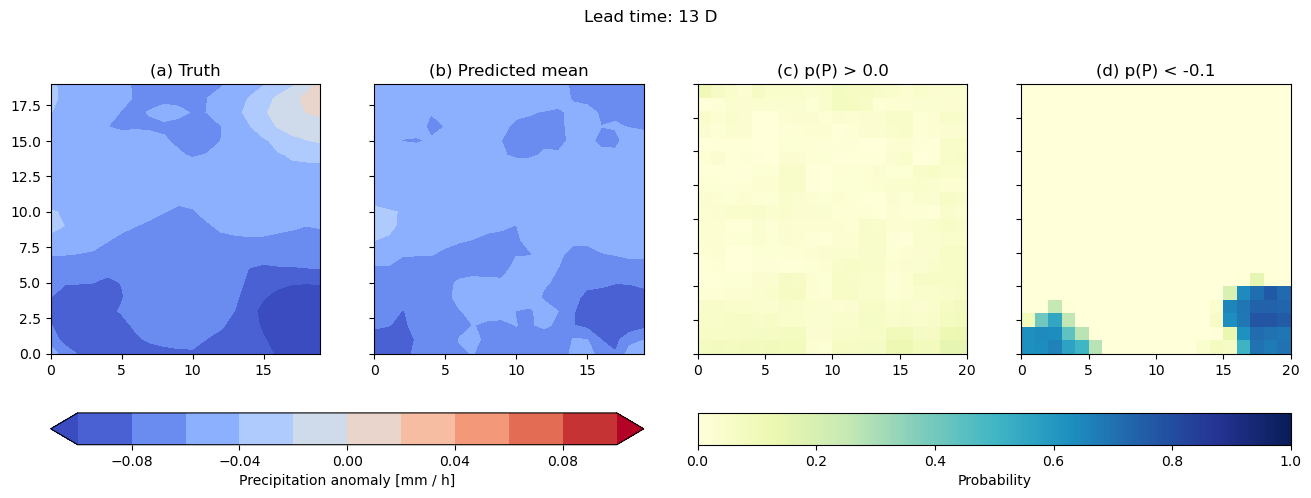

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize

norm = Normalize(-0.1, 0.1)
levels = np.linspace(-0.1, 0.1, 11)

gs = GridSpec(2, 4, height_ratios=[1.0, 0.1])
fig = plt.figure(figsize=(16, 5))

axs = [fig.add_subplot(gs[0, ind]) for ind in range(4)]

m = axs[0].contourf(target, norm=norm, levels=levels, extend="both", cmap="coolwarm")
axs[0].set_title("(a) Truth")
axs[0].set_aspect(1.0)

m = axs[1].contourf(surface_precip_mean[0, 0], norm=norm, levels=levels, extend="both", cmap="coolwarm")
axs[1].set_title("(b) Predicted mean")
axs[1].set_yticklabels([])
axs[1].set_aspect(1.0)

cax = fig.add_subplot(gs[1, :2])
plt.colorbar(m, cax=cax, label="Precipitation anomaly [mm / h]", orientation="horizontal")

m = axs[2].pcolormesh(surface_precip_pos[0, 0], vmin=0, vmax=1, cmap="YlGnBu")
axs[2].set_title("(c) p(P) > 0.0")
axs[2].set_yticklabels([])
axs[2].set_aspect(1.0)

axs[3].pcolormesh(surface_precip_neg[0, 0], vmin=0, vmax=1, cmap="YlGnBu")
axs[3].set_title("(d) p(P) < -0.1")
axs[3].set_yticklabels([])
axs[3].set_aspect(1.0)

cax = fig.add_subplot(gs[1, 2:])
plt.colorbar(m, cax=cax, label="Probability", orientation="horizontal")

fig.suptitle(f"Lead time: {int(batch["lead_time"][0].item() // 24)} D")